---
layout: single
title: "genetic algorithm으로 시험 만점 맞기"
categories: machine_learning
tags: [genetic algorithm]
use_math: true
publish: false
author_profile: false
toc: true
---

이 포스트는 genetic algorithm에 대하여 나름대로 설명해본 것입니다.
이에 관해서는 조금 더 심층적으로 공부하고 싶은 마음이 있어서, genetic algorithm에 관한 [원래 논문](https://link.springer.com/chapter/10.1007/978-3-319-93025-1_4)과 [관련된 survey paper](https://link.springer.com/article/10.1007/s11042-020-10139-6)도 추후에 포스팅하면 좋겠다는 생각을 가지고 있습니다.

처음 관련 내용을 정리했던 것은 2021년 4월이었습니다. 인공지능에 관한 대학원 수업을 들으면서 genentic algorithm에 관해 조사하여 중간과제로 제출해야 했었던 때가 있었는데, 그때 genetic algorithm의 기본에 관해 공부하여 TeX파일로 정리해봤습니다.
당시에는 왠지 영어로 작성해봤었습니다.
해당 내용을 다시 보니 가독성이 조금 별로인 것 같기도 하고 명확하게 표현되지 않은 부분도 있는 것 같아서 이 포스트에서는 한글로 옮겨서, 그리고 설명도 잘 해가면서 적어보려고 합니다.
또한, 기존의 코드들이 대단한 계산을 요구하지는 않지만 그래도 `numpy`에 기반한 빠른 연산방식으로 작성되었다기보다는 `list`의 기본적인 연산들이 주로 활용되어 작성되었으므로, 해당 코드들을 조금 바꿀 수도 있을 것 같습니다.
다만, 경우에 따라서는 아래 링크의 기존 pdf 파일이 더 간결하게 잘 읽힐 수도 있을 것 같습니다.
[링크]({{ site.url }}/assets/pdf/210403_genetic_algorithm.pdf){: .btn .btn--primary}

대학원에 다니는 동안, 교수님을 따라서 랩단위의 세미나를 이곳저곳 많이 다녔습니다.
마지막으로 세미나를 참석했을 때는 제주도에 갔었던 것으로 기억하는데, 거기에서 이 genetic algorithm을 소개하는 발표를 준비했었다가, 발표까지는 하지 못했었습니다.

지금까지의 모든 포스트는 `.md` 파일로 작성했습니다.
하지만 이번 포스트는 코드가 많이 포함되어 있는 만큼 `.ipynb` 파일로 먼저 작성한 후, 그것을 다시 `.md`파일로 [변환](https://nbconvert.readthedocs.io/en/latest/)하여 업로드하는 형태가 될 것 같습니다.
포스트에 등장하는 용어들은 한글로 사용하였고 최초 등장할 때에 한해서만 영어를 병기해보았습니다.
다만, 용어들이 아주 표준적인 용어는 아닐 수 있을 것 같습니다.

# 1 들어가며

학창시절(중학교, 고등학교)에 분기마다 한번씩 영어듣기평가를 봐야 했었습니다.
시험은 문항이 5개인 20개의 객관식 문항들로 구성되어 있었습니다.
이 포스트에서는 genetic algorithm을 통해 시험의 답을 구해나가는 과정을 설명해보았고, 문항을 4개로 두었습니다.
그러니까, genetic algorithm을 설명하는 표준적인 방법은 알기 위해서는 위에 언급한 논문들을 읽어가며 이해하면 되겠지만, 이 포스트의 내용은 genetic algorithm를 제 나름대로 해석하여, ‘객관식 시험 응시하기’ 문제로 치환해본 것입니다.

객관식 문항 20개를 푸는 시험을 생각해봅시다.
각 문항들이 4개의 선지로 되어 있는 4지선다 문제들이라고 하면, 임의로 모든 문항들을 찍었을 때 만점을 받을 확률은 

$$\left(\frac14\right)^{20}\approx8.2718061\times10^{-25}$$

입니다.
백분율로 계산하면

$$0.0000000000000000000000827\%$$

입니다.
그러니까, 너무 당연한 이야기이지만, 문항들을 모두 찍어서는 만점을 맞는 것이 거의 불가능합니다.
하지만, 처음에는 모든 문항들을 찍더라도, 답안을 조금씩 수정할 수 있다면, 그리고 그때마다 채점하여 점수를 조회할 수 있다면 결국은 100점을 받을 수 있을 것입니다.

<!-- ![img](..\assets\images\2023-05-04-genetic_algorithm_1\img.png){: .img-40-center}

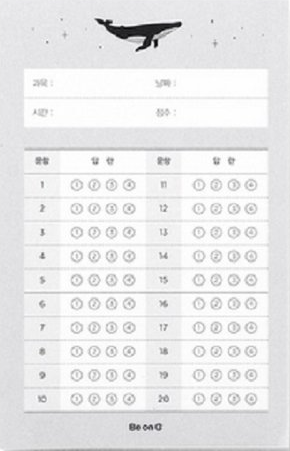

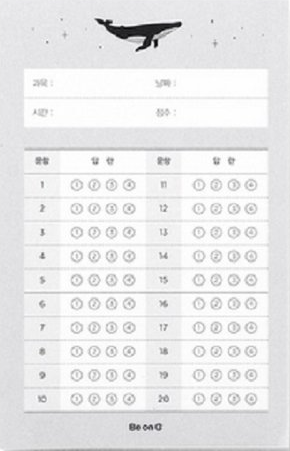{: .img-40-center}

<img src="..\assets\images\2023-05-04-genetic_algorithm_1\img.png" alt="problem" class="center" width="50%">

<img src="img.png" alt="problem" class="center" width="50%">

![img](img.png){: .img-40-center}

![img](img.png)

<img src="img.png"> -->

이 포스트에서는 genetic algorithm을 사용하여 영어듣기평가에서 만점을 받아보는 과정을 살펴봅니다.
시작하기에 앞서 내용을 요약하면, 인구(population size)가 200인 40번의 세대(generation)를 지나면서 자연선택(natural selection)과 짝짓기(pairing), 교배(crossover)와 돌연변이(mutation)를 지속적으로 거치면 높은 확률로(1000번의 실험 중 939번) 만점을 맞을 수 있게 됩니다.
다시 말해, 한 번의 회차마다 200회의 답안을 제출하여 그때마다의 점수를 알 수 있고, 그 점수를 기반으로 다음 회차에는 답안을 조금 변경하여 다시 제출할 수 있을 때, 40회차가 되면 $93.9\%$의 확률로 100점을 받을 수 있게 됩니다.

<div class="notice--danger">
<ul>
    <li>
    사실, genetic algorithm이 이 문제를 푸는 가장 optimal한 방법은 아닐 것 같습니다.
    만약 매 답안에 대하여 채점할 수 있다면, 단순히 각 문항들의 답을 바꿔가면서 답을 알아내는 방법이 더 효율적일 수 있을 것 같습니다.
    하지만, 이 포스트에서는 그냥, genetic algorithm을 이해하기 위한 방편으로 시험에서 만점맞기 문제를 생각해본 것입니다.
    </li>
    <li>
    지금부터 설명하는 genetic algorithm은 수많은 가능한 genetic algorithm들 중의 한 방법입니다.
    그러니까, 세부적인 과정들은 얼마든지 변경될 수 있으며, 그 중에 특정한 한 방법만을 소개하게 될 것 같습니다.
    </li>
</ul>
</div>

# 2 genetic algorithm

In [1]:
import numpy as np
from numpy.random import randint
from numpy.random import rand
import random

이 시험에 대한 하나의 **answer(답)**은 각 성분이 1, 2, 3, 4 중 하나인 20차원의 벡터라고 생각할 수 있습니다.
즉, 만약 $a$가 answer이면

$$a\in\{1,2,3,4\}^{20}$$

입니다.
예를 들어 모든 문항에 대한 답안을 1로 제출한 answer는

$$a_1=(1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1)$$

이고

1, 2, 3, 4를 번갈아가며 제출한 답은

$$a_2=(1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4,1,2,3,4)$$

입니다.

In [2]:
a1 = [1]*20
a2 = [1,2,3,4]*5
print(a1, a2, sep='\n')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]



이 시험에 대한 **정답**도 마찬가지로 $\\{1,2,3,4\\}^{20}$의 원소입니다.
즉, 20차원의 벡터입니다.
정답을 다음과 같이 `right_answer`라는 변수로 나타내보았습니다.

In [3]:
n_choice = 4 # the number of choices in a problem
n_problem = 20 # the number of problems in a test
right_answer = randint(1, 1 + n_choice, n_problem)
right_answer

array([4, 1, 1, 3, 4, 4, 3, 1, 2, 3, 4, 2, 3, 3, 2, 1, 3, 2, 4, 3])

In [4]:
print("즉, 1번의 답은", right_answer[0],"이고, 2번의 답은", right_answer[1],"입니다.")

즉, 1번의 답은 4 이고, 2번의 답은 1 입니다.


`n_cho`는 선지의 개수로 4입니다.
`n_pro`는 문항의 개수로 20입니다.
`right_answer`는 1, 2, 3, 4 중 하나를 뽑는 시행을 20번 반복하여 20차원의 벡터(`np.array`)를 만든 것입니다.

다음으로, 여러 개의 **답안**을 얻어봅니다.
여기에서 '답안'이란, 시험을 통해 제출하는 답안으로 20차원의 벡터이며, 우리는 정답과 최대한 비슷한 답을 제출하기를 원합니다.
한 번 제출할 때, 50개의 답안을 제출하게 됩니다.
그리고 제출할 때마다 각 답안에 대한 점수를 알 수 있어서, 다음 제출 때 이 점수를 참고하여 다시 50개의 답안을 제출하는 방식을 반복할 것입니다.

아래 코드에는 50개의 답을 얻는 과정을 나타낸 것입니다.

In [5]:
n_individual = 50 ### the number of individuals in a population
generation_1 = [randint(1, 1 + n_choice, n_problem).tolist() for _ in range(n_individual)]
np.array(generation_1).shape

(50, 20)

각각의 답들은 개체(individual)라고도 불립니다.
혹은, 개체의 유전 정보가 담겨있다는 점에서 염색체(chromosome)라고 불리기도 합니다.
이 개체들이 50개 모여있는 집합을 세대(generation, population)라고 합니다.
위의 코드에서 `n_individual`는 한 세대에서의 개체의 수로서 50으로 설정되어 있고, 세대는 `generation_1`으로 표시되어 있습니다.

어떤 답이 얼마나 정답과 가까운지 판단하기 위해서는 당연히 채점을 해보면 됩니다.
채점을 위해서는 적합도함수(fitness function)를 정의할 수 있습니다.

In [6]:
def count(tuple1,tuple2):
    assert len(tuple1) == len(tuple2)
    return sum([int(tuple1[i] == tuple2[i]) for i in range(len(tuple1))])

`count` 함수는 길이가 같은 두 개의 tuple(혹은 list-like-objects)을 입력받아서 두 tuple의 각 성분이 몇 개나 일치하는지 셉니다.
만약, `t1`과 `t2`가 길이가 3인 두 `list`이고 일치하는 성분이 두 개이면 `object`함수를 `t1`과 `t2`에 적용했을 때 그 결과가 2로 나옵니다.

In [7]:
t1 = [1,2,3]
t2 = [1,2,4]
count(t1, t2)

2

적합도 함수에 해당하는 $\texttt{score}:\texttt{answer}\mapsto\texttt{count(answer,right\_answer)}$는 각각의 답들을 점수(맞은 문제의 개수)로 환산해주는 역할을 합니다.

<!-- 이제 `score`함수를 $\texttt{score}=\texttt{count}(~\cdot~,\texttt{right\_answer})$로 정의하면

$$\texttt{score}:\{1,2,3,4\}^{20}\to\{0,1,2,\cdots,20\}$$

이 함수는 임의의 답을 그 점수(맞은 문제의 개수)로 환산해주는 역할을 합니다. -->

In [8]:
def score(answer):
    return count(answer, right_answer)

예를 들어, $a_1$과 $a_2$의 점수는 각각

In [9]:
print(score(a1), score(a2), sep='\n')

4
2


입니다.

이번에는 하나의 세대(`generation_1`)에 대하여 각 개체들의 점수들을 기록하는 `list`를 만들어 `scores`라는 변수로 저장해봅니다.

In [10]:
scores = [score(c) for c in generation_1]
np.array(scores)

array([ 3,  8,  2,  3,  3,  5,  4,  5, 11,  7,  7,  8,  5,  4,  6,  4,  6,
        8,  4,  2,  3,  5,  3,  4,  6,  2,  8,  5,  3,  5,  3,  6,  2,  5,
        5,  3, 10,  7,  1,  7,  2,  4,  4,  5,  6,  6,  6,  8,  4,  5])

위 코드에서 확인할 수 있듯, `scores`는 50개의 점수들로 이루어져 있고 각 점수들은 0과 20 사이의 값을 가질 수 있습니다.
조금 더 말해보면, 각각의 점수들은 이항분포 $B\left(20,\frac14\right)$를 따를 것이므로, 평균적으로 $5$ 정도의 값을 가져야 할텐데, 위 코드에 나타난 점수들도 대략적으로 그러한 양상을 띠고 있는 것으로 보입니다.

## 2.1 자연선택(natural selection)

지금까지 첫번째 세대(`generation_1`)를 만들어보았고, 첫번째 세대의 각 개체들에 대하여 점수를 매겨보았습니다.
다음으로 할 것은 두번째 세대를 만드는 것입니다.
첫번째 세대가 50개의 개체로 이루어졌던 것처럼, 마찬가지로 두번째 세대도 50개의 개체로 이루어집니다.
그리고 이 두 번째 세대는 첫번째 세대를 '부모세대'로 하여 얻어지는 '자식세대'이며, 우리는 두번째 세대의 개체들이 첫번재 세대의 개체들보다는 대체로 점수가 잘 나오게끔 만들 예정입니다.
이를 위해서는 부모세대의 모든 개체들을 부모로 삼지 않습니다.
부모세대 중 점수가 높은 일부 개체들만을 선택해 그 개체들을 부모로 삼아서 자식을 생산합니다.
이것을 선택(selection)이라고 하는데, [다윈](https://ko.wikipedia.org/wiki/%EC%B0%B0%EC%8A%A4_%EB%8B%A4%EC%9C%88)([Charles Darwin](https://en.wikipedia.org/wiki/Charles_Darwin))의 「[종의 기원](https://ko.wikipedia.org/wiki/%EC%A2%85%EC%9D%98_%EA%B8%B0%EC%9B%90)([On the Origin of Species](https://en.wikipedia.org/wiki/On_the_Origin_of_Species))」에서 설명되는 [자연선택](https://ko.wikipedia.org/wiki/%EC%9E%90%EC%97%B0%EC%84%A0%ED%83%9D)([natural selection](https://en.wikipedia.org/wiki/Natural_selection))에 해당되는 과정이라 할 만합니다.

이 포스트에서는 두 가지 방식의 선택 방법을 소개해봅니다.
첫번째 선택 방법(`select1`)은 간단합니다.
부모 세대의 개체들 중 3개의 개체들을 임의로 고른 후 그 중 가장 점수가 높은 개체를 선택하는 것입니다.
코드로는 다음과 같이 구현될 수 있습니다.

In [11]:
n_candidate = 3 # the number of candidates among which one selects in select1
def select1(generation, k=n_candidate): # choose k number of individuals randomly and select the fittest
    scores = [count(right_answer,c) for c in generation]
    selection_ix = randint(len(generation))
    for ix in randint(0, len(generation), k-1):
        if scores[ix] > scores[selection_ix]:
            selection_ix = ix
    return generation[selection_ix]

In [12]:
# k = 3
# indices = randint(0,len(pop),k)
# k_selected = []
# for i in range(len(pop)):
#     if i in indices:
#         k_selected.append(scores[i])
#     else:
#         k_selected.append(0)
# np.argmax(k_selected)

In [13]:
np.array(generation_1).shape

(50, 20)

예를 들어, 첫번째 세대(`generation_1`)에 대하여 `select1`을 시행하면 다음과 같이 대체로 높은 점수를 가지는 개체가 출력됩니다.

In [14]:
print(select1(generation_1))
print(score(select1(generation_1)))

[2, 2, 4, 2, 2, 4, 3, 1, 1, 3, 4, 3, 3, 4, 2, 4, 4, 3, 3, 3]
5


물론, 위의 코드는 시행할 때마다 다른 개체를, 그리고 다른 점수를 출력하게 됩니다.

두번째 자연선택방법(`select2`)은, 부모세대의 50개 개체들 중 하나를 임의로 뽑되, 각 개체들의 점수에 비례한 확률로 뽑는 것입니다.
코드로 표시하면 다음과 같습니다.

In [15]:
def select2(generation): # select one individual with probability proportional to the score
    scores = [score(c) for c in generation]
    return np.array(random.choices(generation, weights=scores)).flatten().tolist()

위의 설명과 코드로도 충분한 설명이 되겠지만, 수학적으로 적어보면 다음과 같습니다.
부모세대(첫번째 세대)를 $G_1$이라고 적고, 부모세대의 각 개체들을 $i_n\in\\{1,2,3,4\\}^{20}$이라고 적으면 ($n=1$, $2$, $\cdots$, $50$)

$$G_1=\{i_1,i_2,\cdots,i_{50}\}$$

입니다.
각각의 개체(답) $i_n$에 대한 점수를 $\text{score}(i_n)$이라고 하면 `select2(pop)`를 시행하는 것은 이산확률변수 $I$에 대한 이산확률분포

$$
\begin{cases}
P_I(i_1)&=\frac{\text{score}(i_1)}{\sum_{n=1}^{50}\text{score}(i_n)}\\[10pt]
P_I(i_2)&=\frac{\text{score}(i_2)}{\sum_{n=1}^{50}\text{score}(i_n)}\\[10pt]
&\vdots\\[10pt]
P_I(i_{50})&=\frac{\text{score}(i_{50})}{\sum_{n=1}^{50}\text{score}(i_n)}
\end{cases}
$$

에서 임의로 하나의 값을 뽑는 것을 말합니다.

`pop`에 대하여 `select2`를 시행하면 그 결과는 다음과 같이 나올 수 있습니다.

In [16]:
print(select2(generation_1))
print(score(select2(generation_1)))

[2, 2, 4, 3, 2, 1, 2, 3, 1, 3, 2, 2, 2, 4, 2, 3, 1, 3, 2, 1]
5


위의 두 선택방법(`select1`, `select2`)은 단순히 한 세대의 50개의 개체들 중 하나를 택하는 것만을 의미합니다.
실제로는 이러한 선택을 50번 하여 새로운 50개의 개체들

$$p_1,p_2,\cdots,p_{50}$$

를 만들어냅니다.

In [17]:
select = [_,select1,select2]
sel = 1 ### whether to use selection1 or selection2
selected = [select[sel](generation_1) for _ in range(n_individual)]
print(np.array(generation_1).shape)
print(np.array(selected).shape)

(50, 20)
(50, 20)


위의 코드에서 `selected`는 첫번째 세대인 `generation_1`에 50번의 `select1`을 적용한 것입니다.
따라서, `selected`는 `generation_1`과 마찬가지로, 20차원의 벡터 50개가 모인 것입니다.
자연선택을 하고 나면 각 개체들은 평균적으로 더 나은 적합도 점수를 보이게 됩니다 ;

In [34]:
scores_selected = [score(c) for c in selected]
print('generation_1의 적합도 점수 평균 :', np.mean(scores))
print('selected의 적합도 점수 평균 :', np.mean(scores_selected))

generation_1의 적합도 점수 평균 : 5.38
selected의 적합도 점수 평균 : 7.2


이렇게 선택된 50개의 개체들은 짝짓기(pairing), 교배(crossbreed, crossover), 돌연변이(mutation)를 거쳐서 다음 세대를 만들어냅니다.

## 2.2 짝짓기(pairing)

50개의 개체들은 순서대로 25개의 쌍을 이루어 부모(parents)가 됩니다.
즉, 각각의 부모 개체 $p_n$($n=1$, $2$, $\cdots$, $50$)들을 다음과 같이 아버지(father) $f_{2k-1}$와 어머니(mother) $m_{2k}$으로 다음과 같이 나누면 ($k=1$, $2$, $\cdots$, $25$),

$$
\begin{align*}
f_1&=p_1,&f_2&=p_3,&\cdots,&&f_{25}&=p_{49}\\
m_1&=p_2,&m_2&=p_4,&\cdots,&&m_{25}&=p_{50}
\end{align*}
$$

25개의 부모쌍 $(f_k, m_k)$이 얻어집니다. ($k=1$ ,$2$, $\cdots$, $25$)

## 2.3 교배(crossover)

$f_k$와 $m_k$는 각각 20차원의 벡터들이었습니다.

$$
\begin{align*}
~f_k&=(~f_{k,1},~f_{k,2},\cdots,~f_{k,20})\\
m_k&=(m_{k,1},m_{k,2},\cdots,m_{k,20})
\end{align*}
$$

이 $f_k$와 $m_k$의 각 성분들을 적절히 배합하여 두 개의 개체 $s_k$, $d_k$를 만들어냅니다.
(적당한 알파벳을 찾다가 son과 daughter의 s와 d를 사용했는데, 아들이 남성, 딸이 여성이라는 의미는 없이 그냥 알파벳만 가져온 것입니다.)
$s_k$와 $d_k$를 만들어내는 방법에는 여러 방법이 있겠지만, 간단한 한가지 방법은 다음과 같습니다.
자연수 $0$, $1$, $2$, $\cdots$, $20$ 중에서 임의의 하나의 값을 택해 $l$이라고 하고, $f_k$의 왼쪽 $l$번째 성분들과 $m_k$의 오른쪽 $20-l$번째 성분들을 이어서(concatenate) $s_k$를 만듭니다.
반대로 $m_k$의 왼쪽 $l$번째 성분들과 $f_k$의 오른쪽 $20-l$번째 성분들을 이어서 $d_k$를 만듭니다.
즉,

$$
\begin{align*}
s_k&=(~f_{k,1},~f_{k,2},\cdots,~f_{k,l-1},~f_{k,l}, m_{k,l+1},\cdots, m_{k,20})\\
d_k&=( m_{k,1}, m_{k,2},\cdots, m_{k,l-1}, m_{k,l},~f_{k,l+1},\cdots,~f_{k,20})
\end{align*}
$$

와 같이 $s_k$, $d_k$를 만들 수 있습니다($k=1$, $2$, $\cdots$, $25$).
따라서, $l=20$이면 다음 세대는 이전 세대와 정확히 똑같이 계승되고, $l=0$이면 남녀가 바뀌어서 계승됩니다.

예를 들어, $f_1$과 $m_1$을 가지고 $s_1$과 $d_1$을 계산하는 방식을 코드로 나타내면 다음과 같습니다.

In [19]:
f1 = selected[0] # father
m1 = selected[1] # mother
pt = randint(n_problem) # partition number
s1 = f1[:pt] + m1[pt:] # son
d1 = m1[:pt] + f1[pt:] # daughter
print('father :', f1)
print('mother :',m1)
print('partition number(l) :', pt)
print('son :', s1)
print('daughter :', d1)

father : [1, 3, 1, 1, 3, 3, 4, 3, 4, 2, 1, 2, 3, 4, 3, 4, 3, 1, 2, 2]
mother : [1, 2, 1, 3, 4, 3, 3, 2, 3, 4, 3, 3, 2, 4, 4, 1, 3, 2, 2, 3]
partition number(l) : 6
son : [1, 3, 1, 1, 3, 3, 3, 2, 3, 4, 3, 3, 2, 4, 4, 1, 3, 2, 2, 3]
daughter : [1, 2, 1, 3, 4, 3, 4, 3, 4, 2, 1, 2, 3, 4, 3, 4, 3, 1, 2, 2]


실제 코드 구현에서는 항상 교배가 일어나는 것은 아니며, 0.9의 확률로만 교배가 일어난다고 두었습니다.

In [20]:
r_crossover= .9 ### the rate of crossover

def crossover(f, m, r_crossover): # father, mother
    s, d = f.copy(), m.copy() # son, daughter
    if rand() < r_crossover:
        pt = randint(n_problem) # partition number(l)
        s = f[:pt] + m[pt:]
        d = m[:pt] + f[pt:]
    return [s, d]

crossover(f1, m1, r_crossover)

[[1, 3, 1, 3, 4, 3, 3, 2, 3, 4, 3, 3, 2, 4, 4, 1, 3, 2, 2, 3],
 [1, 2, 1, 1, 3, 3, 4, 3, 4, 2, 1, 2, 3, 4, 3, 4, 3, 1, 2, 2]]

## 2.4 돌연변이(mutation)

이러한 짝짓기와 교배를 하고 나면 50개의 새로운 개체 $s_1$, $d_1$, $s_2$, $d_2$, $\cdots$, $s_{25}$, $d_{25}$가 생기는 셈입니다.
이것들(children)을 차례대로 $c_1$, $c_2$, $\cdots$, $c_{50}$이라고 하면, 즉,

$$
\begin{align*}
c_1&=s_1,&c_3&=s_2,&\cdots,&&c_{49}&=s_{25}\\
c_2&=d_1,&c_4&=d_2,&\cdots,&&c_{50}&=d_{25}
\end{align*}
$$

이라고 두면, $c_n$들은 새로운 세대를 이룬다고 볼 수 있습니다.

하지만, 다음 세대에 조금 더 다양성을 주기 위해서 돌연변이의 개념을 도입할 수 있습니다.
돌연변이는 여러 방식으로 구현할 수 있겠지만, 여기에서는 additive inverse modulo 5 (mod 5인 덧셈의 역원)을 활용합니다.
즉, $s_k$와 $d_k$들은 모두 20차원의 벡터들이고 그 성분이 각각 $1$, $2$, $3$, $4$ 중의 하나라고 했었는데, 각각의 $k=1$, $2$, $\cdots$, $25$에 대하여 $s_k$와 $d_k$의 각각의 성분들에

$$
\begin{align*}
1&\mapsto4\\
2&\mapsto3\\
3&\mapsto2\\
4&\mapsto1
\end{align*}
$$

의 변환을 적용합니다.

첫번째 자식쌍(`s1`, `d1`)에 돌연변이를 적용하는 코드는 다음과 같습니다.

In [21]:
tuple1 = np.array([s1, d1])
print("before mutation :")
print(tuple1)
for i in range(len(tuple1)):
    tuple1[i] = 5 - tuple1[i]
print("after mutation")
print(tuple1)

before mutation :
[[1 3 1 1 3 3 3 2 3 4 3 3 2 4 4 1 3 2 2 3]
 [1 2 1 3 4 3 4 3 4 2 1 2 3 4 3 4 3 1 2 2]]
after mutation
[[4 2 4 4 2 2 2 3 2 1 2 2 3 1 1 4 2 3 3 2]
 [4 3 4 2 1 2 1 2 1 3 4 3 2 1 2 1 2 4 3 3]]


실제 코드 구현에서는 돌연변이가 아주 적은 확률(0.05)로만 나타나도록 했습니다.

In [22]:
r_mutation = 0.05 ### the rate of mutation

def mutation(tuple, r_mutation):
    for i in range(len(tuple)):
        if rand() < r_mutation:
            tuple[i] = 5 - tuple[i]
tuple1 = np.array([s1, d1])
# #tuple1_copied = np.copy(tuple1)
# print(tuple1)
# mutation(tuple1, r_mutation)
# print(tuple1)
# #print((tuple1==tuple1_copied).all())

지금까지 한 것을 요약하면 다음과 같습니다.
- 정답(`right answer`)을 생성하고
- 첫번째 세대 (50개의 답, `generation_1`)를 생성하고
- 자연선택, 짝짓기, 교배, 돌연변이를 사용해 두번째 세대(`generation_2`)를 얻는

과정을 살펴보았습니다.
이 전체 과정을 코드로 한번에 쓰면 다음과 같습니다.

In [41]:
import numpy as np
from numpy.random import randint
from numpy.random import rand
import random

# 세팅
n_choice = 4 # the number of choices in a problem
n_problem = 20 # the number of problems in a test
right_answer = randint(1, 1 + n_choice, n_problem)

# 첫번째 세대 생성
n_individual = 50 ### the number of individuals in a population
generation_1 = [randint(1, 1 + n_choice, n_problem).tolist() for _ in range(n_individual)]

def count(tuple1,tuple2):
    assert len(tuple1) == len(tuple2)
    return sum([int(tuple1[i] == tuple2[i]) for i in range(len(tuple1))])

def score(answer):
    return count(answer, right_answer)

scores = [score(c) for c in generation_1]

# 2.1 자연선택
n_candidate = 3 # the number of candidates among which one selects in select1
def select1(generation, k=n_candidate): # choose k number of individuals randomly and select the fittest
    scores = [count(right_answer,c) for c in generation]
    selection_ix = randint(len(generation))
    for ix in randint(0, len(generation), k-1):
        if scores[ix] > scores[selection_ix]:
            selection_ix = ix
    return generation[selection_ix]

def select2(generation): # select one individual with probability proportional to the score
    scores = [score(c) for c in generation]
    return np.array(random.choices(generation, weights=scores)).flatten().tolist()

select = [_,select1,select2]
sel = 1 ### whether to use selection1 or selection2
selected = [select[sel](generation_1) for _ in range(n_individual)]

# 2.2 짝짓기, 2.3 교배

r_crossover= .9 ### the rate of crossover

def crossover(f, m, r_crossover): # father, mother
    s, d = f.copy(), m.copy() # son, daughter
    if rand() < r_crossover:
        pt = randint(n_problem) # partition number(l)
        s = f[:pt] + m[pt:]
        d = m[:pt] + f[pt:]
    return [s, d]

r_mutation = 0.05 ### the rate of mutation

# 2.4 돌연변이

def mutation(tuple, r_mutation):
    for i in range(len(tuple)):
        if rand() < r_mutation:
            tuple[i] = 5 - tuple[i]

generation_2 = list()
for i in range(0, n_individual, 2):
    f, m = selected[i], selected[i+1]
    for children in crossover(f, m, r_crossover):
        mutation(children, r_mutation)
        generation_2.append(children)

첫번째 세대에서 두 번째 세대를 거치면서 적합도 점수의 평균은 조금 상승합니다.
하지만 자연선택 직후의 적합도 점수의 평균과는 큰 차이가 있지는 않습니다.
즉, 자연선택을 통해 괜찮은 개체들만을 선별한 것에서 적합도 점수의 증가는 끝납니다.
이후에 개체를 임의로 변형(crossover, mutation)해서 다양한 종류의 개체들에 대한 가능성을 열어두는 것입니다.

In [42]:
print('generation_1의 적합도 점수 평균 :', np.mean(scores))
scores_selected = [score(c) for c in selected]
print('selected의 적합도 점수 평균 :', np.mean(scores_selected))
scores_2 = [score(c) for c in generation_2]
print('generation_2의 적합도 점수 평균 :', np.mean(scores_2))

generation_1의 적합도 점수 평균 : 4.88
selected의 적합도 점수 평균 : 6.76
generation_2의 적합도 점수 평균 : 6.76


# 3 실험

지금까지, 한 세대에 대한 genetic algorithm을 알아보았습니다.
이것을 여러 세대에 걸쳐 반복하면, 정말로 성능의 향상을 가져올 수 있을 것입니다(3.1).
그런데 이와 같은 기본모델은 여러 hyperparameter들을 꽤 임의로 설정한 것입니다.
이러한 hyperparameter들을 변경하여 더 괜찮은 성능을 낼 수 있도록 해보았습니다(3.2).

먼저, 아래와 같이 문제를 세팅합니다.
4지선다형 문항 20개에 대한 답안을 제출하는 일을 생각할 때, 40번의 세대를 거치면서 만점 답안을 제출할 수 있는 문제입니다.

In [68]:
import numpy as np
from numpy.random import randint
from numpy.random import rand
import matplotlib.pyplot as plt
import random

right_answer = randint(1, 1 + n_choice, n_problem)
n_choice = 4 # the number of choices in a problem
n_problem = 20 # the number of problems in a test
n_generation = 40 # the number of generations

## 3.1 기본모델

2절에서 설명한 기본적인 모델을 함수 `implementation`로 구현해보았습니다.

In [74]:
# Hyperparameters
n_individual = 50 ### the number of individuals in a population
sel = 1 ### whether to use selection1 or selection2
n_candidate = 3 # the number of candidate which one selects upon in select1
r_crossover = .9 ### the rate of crossover
r_mutation = 0.05 ### the rate of mutation

# Helper functions
def count(tuple1,tuple2):
    return sum([int(tuple1[i] == tuple2[i]) for i in range(len(tuple1))])

def score(answer):
    return count(answer, right_answer)

def select1(generation, k=n_candidate): # choose k number of individuals randomly and select the fittest
    scores = [score(c) for c in generation]
    selection_ix = randint(len(generation))
    for ix in randint(0, len(generation), k-1):
        if scores[ix] > scores[selection_ix]:
            selection_ix = ix
    return generation[selection_ix]

def select2(generation): # select one individual with probability proportional to the score
    scores = [score(c) for c in generation]
    return np.array(random.choices(generation, weights=scores)).flatten().tolist()

select=[_, select1, select2]

def crossover(f, m, r_crossover): # father, mother
    s, d = f.copy(), m.copy() # son, daughter
    if rand() < r_crossover:
        pt = randint(n_problem) # partition number(l)
        s = f[:pt] + m[pt:]
        d = m[:pt] + f[pt:]
    return [s, d]

def mutation(tuple, r_mutation):
    for i in range(len(tuple)):
        if rand() < r_mutation:
            tuple[i] = 5 - tuple[i]

def implementation(n_individual=50, sel=1, r_crossover=.9, r_mutation=0.05):
    generation = [randint(1, 1 + n_choice, n_problem).tolist() for _ in range(n_individual)]
    scores_avg, scores_max = list(), list()
    for gen in range(n_generation):
        scores = [score(c) for c in generation]
        scores_avg.append(np.mean(scores))
        scores_max.append(max(scores))
        #print(">generation %d : the average score is %.3f" % (gen,np.mean(scores)))
        selected = [select[sel](generation) for _ in range(n_individual)]
        generation = list()
        for i in range(0, n_individual, 2):
            f, m = selected[i], selected[i+1]
            for children in crossover(f, m, r_crossover):
                mutation(children, r_mutation)
                generation.append(children)
    return scores_avg, scores_max

함수 `implementation`은 다음과 같은 인자들을 가집니다.

<ul>
    <li> <code> n_individual </code> : 한 세대의 개체수 (default : <code> 50 </code>)</li>
    <li> <code> sel </code> : 자연선택 방법 (default : <code> 1 </code>)</li>
    <li> <code> r_crossover </code> : 교배 확률 (default : <code> 0.9 </code>)</li>
    <li> <code> r_mutation </code> : 돌연변이 확률 (default : <code> 0.05 </code>)</li>
</ul>

`implementation`은 두 개의 결과값 `scores_avg`, `scores_max`를 반환합니다.
<ul>
    <li> <code> scores_avg </code> : 각 세대별 평균점수</li>
    <li> <code> scores_max </code> : 각 세대별 최고점수</li>
</ul>

각각을 출력해보면 `scores_avg`는

In [84]:
scores_avg, scores_max = implementation()
print(scores_avg)

[5.5, 7.68, 8.9, 9.76, 11.26, 12.12, 12.66, 12.92, 13.28, 14.24, 14.48, 15.46, 15.42, 16.04, 16.28, 16.16, 16.34, 16.42, 16.9, 16.74, 16.8, 17.26, 17.38, 17.32, 17.18, 17.4, 17.46, 17.28, 17.28, 17.18, 17.32, 17.36, 17.18, 17.24, 17.18, 17.52, 17.34, 17.4, 17.22, 17.26]
[10, 11, 13, 13, 15, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


와 같이 나타납니다.
다시 말해, 세대를 거쳐감에 따라 평균점수가 계속 상승하는 경향을 띠는 것을 볼 수 있습니다.
또한, `scores_max`는

In [85]:
print(scores_max)

[10, 11, 13, 13, 15, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]


와 같이 나타납니다.
최고점수 또한 증가하는 경향을 띠고 있습니다.
또한,
40번째 세대를 이루는 50개의 개체들 중에는 만점을 받는 개체가 있거나 만점에 가까운 개체가 있음을 알 수 있습니다.

<function matplotlib.pyplot.show(close=None, block=None)>

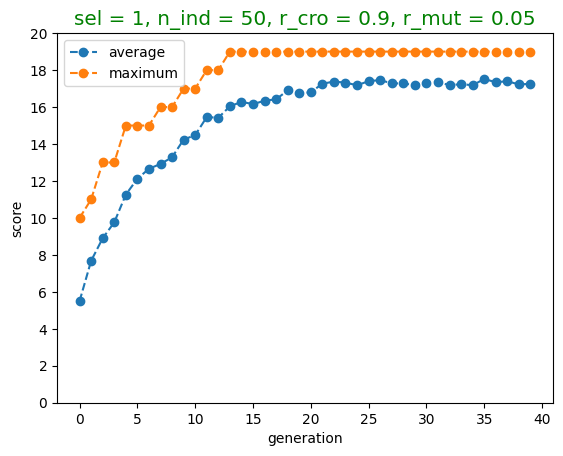

In [91]:
x = range(n_generation)
plt.plot(x, scores_avg, label = "average", linestyle='dashed',marker='o')
plt.plot(x, scores_max, label = "maximum", linestyle='dashed',marker='o')
plt.xlabel('generation')
plt.ylabel('score')
plt.title('sel = '+str(sel)+', n_ind = '+str(n_individual)+', r_cro = '+str(r_crossover)+', r_mut = '+str(r_mutation), color = 'g', fontsize = 'x-large')
plt.legend()
plt.xticks(np.arange(0, 41, 5))
plt.yticks(np.arange(0, 21, 2))
plt.show

## 3.2 변경모델

### 3.2.1 자연선택

### 3.2.2 각 세대당 개체 수

### 3.2.3 교배비율

### 3.2.4 돌연변이 비율

# 4. 결론

In [43]:
import random
from numpy.random import randint
from numpy.random import rand
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
n_cho = 4 # the number of choices in a problem
n_pro = 20 # the number of problems in a test
n_ind = 50 ### the number of individuals in a population
n_gen = 40 # the number of generations
n_can = 3 # the number of candidate which one selects upon in select1
r_cro = .9 ### the rate of crossover
r_mut = 0.05 ### the rate of mutation
sel = 1 ### whether to use selection1 or selection2

# Helper functions
def count(tuple1,tuple2):
    return sum([int(tuple1[i] == tuple2[i]) for i in range(len(tuple1))])

def select1(pop, scores, k=n_can): # choose k number of individuals randomly and select the fittest
	selection_ix = randint(len(pop))
	for ix in randint(0, len(pop), k-1):
		if scores[ix] > scores[selection_ix]:
			selection_ix = ix
	return pop[selection_ix]

def select2(pop, scores): # select one individual with probability proportional to the score
	return np.array(random.choices(pop,weights=scores)).flatten().tolist()

select=[_,select1,select2]

def crossover(p1, p2, r_cross):
	c1, c2 = p1.copy(), p2.copy()
	if rand() < r_cross:
		pt = randint(1, len(p1)-2)
		c1 = p1[:pt] + p2[pt:]
		c2 = p2[:pt] + p1[pt:]
	return [c1, c2]

def mutation(tuple, r_mut):
    for i in range(len(tuple)):
        if rand() < r_mut:
            #tuple[i] = (5 - tuple[i]) % 5
            tuple[i] = 5 - tuple[i]

def implementation(sel = 1, n_ind = 50, r_cro = .9, r_mut = 0.05):
    pop = [randint(1, 1 + n_cho, n_pro).tolist() for _ in range(n_ind)]
    y_avg, y_max = list(), list()
    for gen in range(n_gen):
        scores = [count(right_answer,c) for c in pop]
        y_avg.append(np.mean(scores))
        y_max.append(max(scores))
        #print(">generation %d : the average score is %.3f" % (gen,np.mean(scores)))
        selected = [select[sel](pop, scores) for _ in range(n_ind)]
        children = list()
        for i in range(0, n_ind, 2):
            p1, p2 = selected[i], selected[i+1]
            for c in crossover(p1, p2, r_cro):
                mutation(c,r_mut)
                children.append(c)
        pop = children
    return y_avg,y_max

In [48]:
implementation()[0]

[4.8,
 6.28,
 7.7,
 8.96,
 9.88,
 10.54,
 11.02,
 11.58,
 12.38,
 12.88,
 13.18,
 13.78,
 14.2,
 14.32,
 14.52,
 14.9,
 15.06,
 15.34,
 15.74,
 16.06,
 16.22,
 16.52,
 16.64,
 17.24,
 17.12,
 16.94,
 16.8,
 17.1,
 17.44,
 17.62,
 17.68,
 18.0,
 18.34,
 18.56,
 18.72,
 18.58,
 18.62,
 18.5,
 18.6,
 18.52]

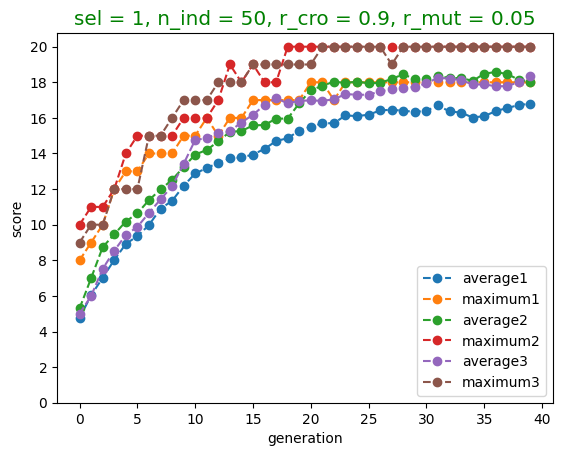

In [25]:
for imp in range(1,4):
    right_answer = randint(1, 1 + n_cho, n_pro)
    y_avg,y_max = implementation(sel = sel, n_ind = n_ind, r_cro = r_cro, r_mut = r_mut)
    x = range(len(y_avg))
    plt.plot(x, y_avg, label = "average"+str(imp), linestyle='dashed',marker='o')
    plt.plot(x, y_max, label = "maximum"+str(imp), linestyle='dashed',marker='o')
    plt.xlabel('generation')
    plt.ylabel('score')
    plt.title('sel = '+str(sel)+', n_ind = '+str(n_ind)+', r_cro = '+str(r_cro)+', r_mut = '+str(r_mut), color = 'g', fontsize = 'x-large')
    plt.legend()
    plt.xticks(np.arange(0, 41, 5))
    plt.yticks(np.arange(0, 21, 2))
    plt.show
    plt.savefig('1_default_model_1')

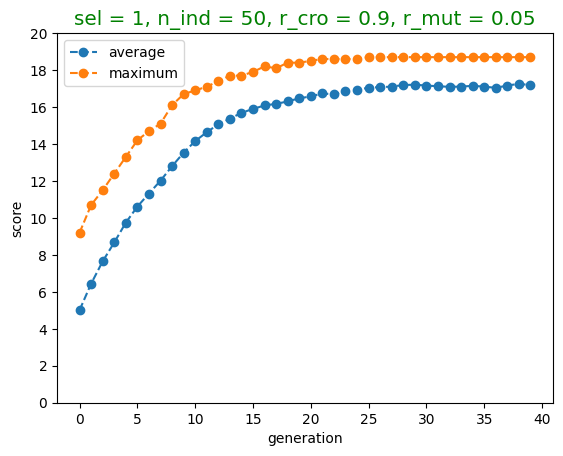

In [26]:
Y_avg, Y_max = list(), list()
for imp in range(10):
    right_answer = randint(1, 1 + n_cho, n_pro)
    y_avg, y_max = implementation(sel = sel, n_ind = n_ind, r_cro = r_cro, r_mut = r_mut)
    Y_avg.append(y_avg), Y_max.append(y_max)
Y_avg = np.array(Y_avg)
Y_max = np.array(Y_max)

y_avg = np.mean(Y_avg, axis=0)
y_max = np.mean(Y_max, axis=0)
x = range(len(y_avg))
plt.plot(x, y_avg, label = "average", linestyle='dashed',marker='o')
plt.plot(x, y_max, label = "maximum", linestyle='dashed',marker='o')
plt.xlabel('generation')
plt.ylabel('score')
plt.title('sel = '+str(sel)+', n_ind = '+str(n_ind)+', r_cro = '+str(r_cro)+', r_mut = '+str(r_mut), color = 'g', fontsize = 'x-large')
plt.legend()
plt.xticks(np.arange(0, 41, 5))
plt.yticks(np.arange(0, 21, 2))
plt.show
plt.savefig('1_default_model_2')

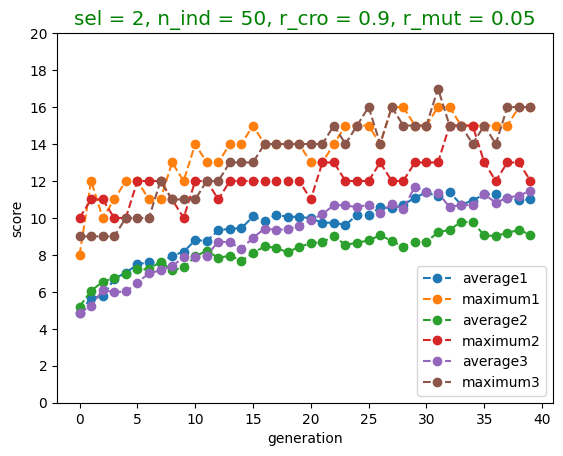

In [27]:
sel = 2
for imp in range(1,4):
    right_answer = randint(1, 1 + n_cho, n_pro)
    y_avg,y_max = implementation(sel = sel, n_ind = n_ind, r_cro = r_cro, r_mut = r_mut)
    x = range(len(y_avg))
    plt.plot(x, y_avg, label = "average"+str(imp), linestyle='dashed',marker='o')
    plt.plot(x, y_max, label = "maximum"+str(imp), linestyle='dashed',marker='o')
    plt.xlabel('generation')
    plt.ylabel('score')
    plt.title('sel = '+str(sel)+', n_ind = '+str(n_ind)+', r_cro = '+str(r_cro)+', r_mut = '+str(r_mut), color = 'g', fontsize = 'x-large')
    plt.legend()
    plt.xticks(np.arange(0, 41, 5))
    plt.yticks(np.arange(0, 21, 2))
    plt.show
    plt.savefig('2_selection_strategies_1.png')

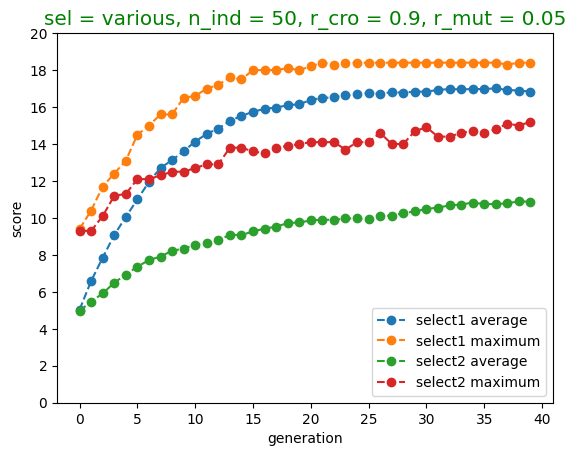

In [28]:
sel = 1 # '1', 2
n_ind = 50 # 10, 20, '50', 100, 200
r_cro = .9 # 0, .5, .9, 1
r_mut = 0.05 # 0, .01, .05, .1, .5, 1
right_answer = randint(1, 1 + n_cho, n_pro)

Y_avg, Y_max = list(), list()
for imp in range(10):
    right_answer = randint(1, 1 + n_cho, n_pro)
    y_avg, y_max = implementation(sel = sel, n_ind = n_ind, r_cro = r_cro, r_mut = r_mut)
    Y_avg.append(y_avg), Y_max.append(y_max)
Y_avg = np.array(Y_avg)
Y_max = np.array(Y_max)

y_avg_1 = np.mean(Y_avg, axis=0)
y_max_1 = np.mean(Y_max, axis=0)

sel = 2 # '1', 2

right_answer = randint(1, 1 + n_cho, n_pro)
y_avg, y_max = implementation(sel = sel, n_ind = n_ind, r_cro = r_cro, r_mut = r_mut)

Y_avg, Y_max = list(), list()
for imp in range(10):
    right_answer = randint(1, 1 + n_cho, n_pro)
    y_avg, y_max = implementation(sel = sel, n_ind = n_ind, r_cro = r_cro, r_mut = r_mut)
    Y_avg.append(y_avg), Y_max.append(y_max)
Y_avg = np.array(Y_avg)
Y_max = np.array(Y_max)

y_avg_2 = np.mean(Y_avg, axis=0)
y_max_2 = np.mean(Y_max, axis=0)

x = range(len(y_avg))
plt.plot(x, y_avg_1, label = "select1 average", linestyle='dashed',marker='o')
plt.plot(x, y_max_1, label = "select1 maximum", linestyle='dashed',marker='o')
plt.plot(x, y_avg_2, label = "select2 average", linestyle='dashed',marker='o')
plt.plot(x, y_max_2, label = "select2 maximum", linestyle='dashed',marker='o')
plt.xlabel('generation')
plt.ylabel('score')
plt.title('sel = various, n_ind = '+str(n_ind)+', r_cro = '+str(r_cro)+', r_mut = '+str(r_mut), color = 'g', fontsize = 'x-large')
plt.legend()
plt.xticks(np.arange(0, 41, 5))
plt.yticks(np.arange(0, 21, 2))
plt.show
plt.savefig('2_selection_strategies_2.png')

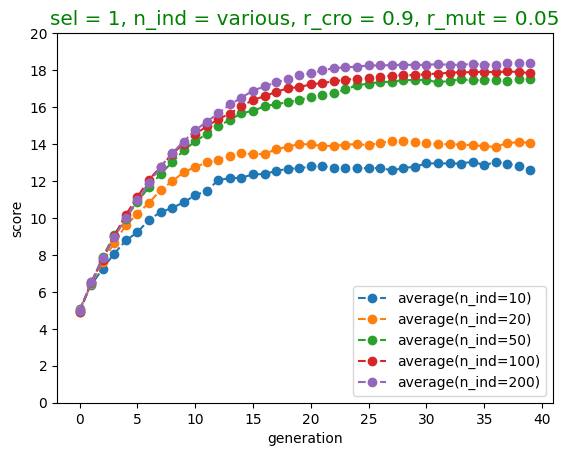

In [29]:
    sel = 1 # '1', 2
    N_ind = [10, 20, 50, 100, 200]
    r_cro = .9 # 0, .5, .9, 1
    r_mut = 0.05 # 0, .01, .05, .1, .5, 1

    Y_avg_, Y_max_ = list(), list()
    for n_ind in N_ind:
        right_answer = randint(1, 1 + n_cho, n_pro)
        Y_avg, Y_max = list(), list()
        for imp in range(10):
            right_answer = randint(1, 1 + n_cho, n_pro)
            y_avg, y_max = implementation(sel = sel, n_ind = n_ind, r_cro = r_cro, r_mut = r_mut)
            Y_avg.append(y_avg), Y_max.append(y_max)
        Y_avg = np.array(Y_avg)
        Y_max = np.array(Y_max)
        y_avg_ = np.mean(Y_avg, axis=0)
        y_max_ = np.mean(Y_max, axis=0)
        Y_avg_.append(y_avg_), Y_max_.append(y_max_)
    x = range(n_gen)
    for i in range(len(N_ind)):
        plt.plot(x, Y_avg_[i], label = "average(n_ind="+str(N_ind[i])+")", linestyle='dashed',marker='o')
        #plt.plot(x, Y_max_[i], label = "maximum(n_ind="+str(N_ind[i])+")", linestyle='dashed',marker='o')
    plt.xlabel('generation')
    plt.ylabel('score')
    plt.title('sel = '+str(sel)+', n_ind = various, r_cro = '+str(r_cro)+', r_mut = '+str(r_mut), color = 'g', fontsize = 'x-large')
    plt.legend()
    plt.xticks(np.arange(0, 41, 5))
    plt.yticks(np.arange(0, 21, 2))
    plt.show
    plt.savefig('3_n_ind.png')

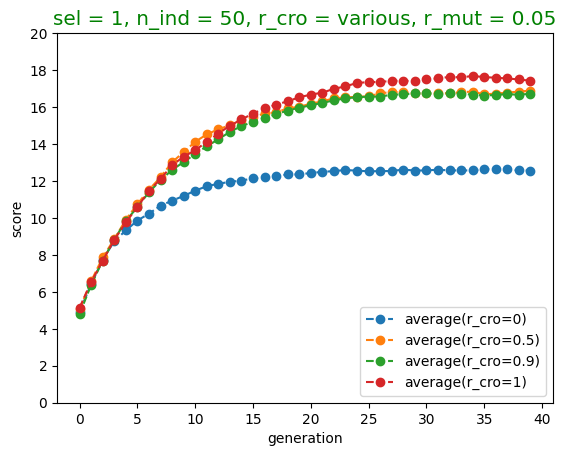

In [30]:
sel = 1 # '1', 2
n_ind = 50 # 10, 20, '50', 100, 200
#r_cro = .9 # 0, .5, .9, 1
R_cro = [0, .5, .9, 1]
r_mut = 0.05 # 0, .01, .05, .1, .5, 1

Y_avg_, Y_max_ = list(), list()
for r_cro in R_cro:
    right_answer = randint(1, 1 + n_cho, n_pro)
    Y_avg, Y_max = list(), list()
    for imp in range(10):
        right_answer = randint(1, 1 + n_cho, n_pro)
        y_avg, y_max = implementation(sel = sel, n_ind = n_ind, r_cro = r_cro, r_mut = r_mut)
        Y_avg.append(y_avg), Y_max.append(y_max)
    Y_avg = np.array(Y_avg)
    Y_max = np.array(Y_max)
    y_avg_ = np.mean(Y_avg, axis=0)
    y_max_ = np.mean(Y_max, axis=0)
    Y_avg_.append(y_avg_), Y_max_.append(y_max_)
x = range(n_gen)
for i in range(len(R_cro)):
    plt.plot(x, Y_avg_[i], label = "average(r_cro="+str(R_cro[i])+")", linestyle='dashed',marker='o')
    #plt.plot(x, Y_max_[i], label = "maximum(n_ind="+str(N_ind[i])+")", linestyle='dashed',marker='o')
plt.xlabel('generation')
plt.ylabel('score')
plt.title('sel = '+str(sel)+', n_ind = '+str(n_ind)+', r_cro = various, r_mut = '+str(r_mut), color = 'g', fontsize = 'x-large')
plt.legend()
plt.xticks(np.arange(0, 41, 5))
plt.yticks(np.arange(0, 21, 2))
plt.show
plt.savefig('4_r_cro.png')

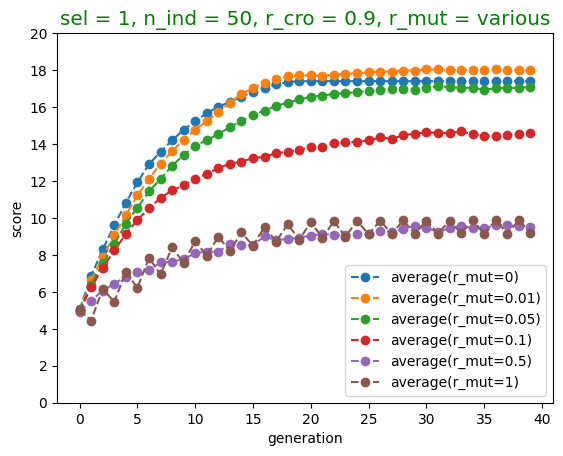

In [31]:
### sel = 1 # '1', 2
n_ind = 50 # 10, 20, '50', 100, 200
r_cro = .9 # 0, .5, .9, 1
R_mut = [0, .01, .05, .1, .5, 1]
#r_mut = 0.05 # 0, .01, .05, .1, .5, 1

Y_avg_, Y_max_ = list(), list()
for r_mut in R_mut:
    right_answer = randint(1, 1 + n_cho, n_pro)
    Y_avg, Y_max = list(), list()
    for imp in range(10):
        right_answer = randint(1, 1 + n_cho, n_pro)
        y_avg, y_max = implementation(sel = sel, n_ind = n_ind, r_cro = r_cro, r_mut = r_mut)
        Y_avg.append(y_avg), Y_max.append(y_max)
    Y_avg = np.array(Y_avg)
    Y_max = np.array(Y_max)
    y_avg_ = np.mean(Y_avg, axis=0)
    y_max_ = np.mean(Y_max, axis=0)
    Y_avg_.append(y_avg_), Y_max_.append(y_max_)
x = range(n_gen)
for i in range(len(R_mut)):
    plt.plot(x, Y_avg_[i], label = "average(r_mut="+str(R_mut[i])+")", linestyle='dashed',marker='o')
plt.xlabel('generation')
plt.ylabel('score')
plt.title('sel = '+str(sel)+', n_ind = '+str(n_ind)+', r_cro = '+str(r_cro)+', r_mut = various', color = 'g', fontsize = 'x-large')
plt.legend()
plt.xticks(np.arange(0, 41, 5))
plt.yticks(np.arange(0, 21, 2))
plt.show
plt.savefig('5_r_mut.png')

In [32]:
from tqdm import tqdm
Y_max = list()
for i in tqdm(range(1000)):
    right_answer = randint(1, 1 + n_cho, n_pro)
    y_avg,y_max = implementation(sel = 1, n_ind = 200, r_cro = 0.9, r_mut = 0.01)
    Y_max.append(y_max[-1])
N=Y_max.count(20)
print(str(N)+' out of 1000 achieve the full score.')

  1%|▏         | 13/1000 [00:05<06:56,  2.37it/s]


KeyboardInterrupt: 